In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import gmean

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc

np.random.seed(42069)
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:

params = {
    'figure.figsize': (10, 5)
     }
plt.rcParams.update(params)

In [3]:
liststocks= {"SPY","DXY"}


for i in tickers:

# This will download data from yahoo finance - more than enough for prototyping
    df = yf.download(
        # tickers list or string as well
        tickers = "SPY DXY AAPL",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5y",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

NameError: name 'tickers' is not defined

In [68]:
df.shape

NameError: name 'df' is not defined

In [5]:
def count_annotation(Data, name, onwhat, what_bull, what_bear, td, window = 50):
    
    Plottable = Data[-window:, ]
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.grid()
    
    ax.plot(Plottable[:, onwhat], color = 'black', linewidth = 1.5, label = name)
    
    for i in range(len(Plottable)):
        
        if Plottable[i, what_bull] < 0 and Plottable[i, what_bull] != -td:
            
            x = i
            y = Plottable[i, onwhat]
        
            ax.annotate(int(Plottable[i, what_bull]), xy = (x, y), textcoords = "offset points", xytext = (0, - 10), ha = 'center',
                        color = 'blue')
            
        elif Plottable[i, what_bull] == -td:
            
            x = i
            y = Plottable[i, onwhat]
        
            ax.annotate(int(Plottable[i, what_bull]), xy = (x, y), textcoords = "offset points", xytext = (0, - 10), ha = 'center',
                        color = 'red')
            
        elif Plottable[i, what_bear] > 0 and Plottable[i, what_bear] != td:
            
            x = i
            y = Plottable[i, onwhat]
        
            ax.annotate(int(Plottable[i, what_bear]), xy = (x, y), textcoords = "offset points", xytext = (0, 10), ha = 'center',
                        color = 'blue' )

        elif Plottable[i, what_bear] == td:
            
            x = i
            y = Plottable[i, onwhat]
        
            ax.annotate(int(Plottable[i, what_bear]), xy = (x, y), textcoords = "offset points", xytext = (0, 10), ha = 'center',
                        color = 'red' )
                     
    ax.set_facecolor((0.95, 0.95, 0.95)) 
    plt.legend()
    
def adder(Data, times):
    
    for i in range(1, times + 1):
    
        new = np.zeros((len(Data), 1), dtype = float)
        Data = np.append(Data, new, axis = 1)

    return Data

def adder_pd(Data, times):
    
    for i in range(1, times + 1):
    
        new = np.zeros((len(Data), 1), dtype = float)
        Data = np.append(Data, new, axis = 1)

    return Data

def deleter(Data, index, times):
    
    for i in range(1, times + 1):
    
        Data = np.delete(Data, index, axis = 1)

    return Data
   
def jump(Data, jump):
    
    Data = Data[jump:, ]
    
    return Data

def rounding(Data, how_far):
    
    Data = Data.round(decimals = how_far)
    
    return Data
            







def rolling_correlation(Data, first_data, second_data, lookback, where):
    
    # Adding an extra column
    Data = adder(Data, 1)
    
    for i in range(len(Data)):
        
        try:
            Data[i, where] = pearsonr(Data[i - lookback + 1:i + 1, first_data], Data[i - lookback + 1:i + 1, second_data])[0]
            
             
        except ValueError:
            pass
    
    Data = jump(Data, lookback) 
    
    return Data

def auto_correlation(Data, first_data, second_data, shift_degree, lookback, where):
    
    new_array = shift(Data[:, first_data], shift_degree, cval = 0)
    new_array = np.reshape(new_array, (-1, 1))
    
    Data = np.concatenate((Data, new_array), axis = 1)
    Data = adder(Data, 1)
    
    for i in range(len(Data)):
        
        try:
            Data[i, where] = pearsonr(Data[i - lookback + 1:i + 1, first_data], Data[i - lookback + 1:i + 1, second_data])[0]
            
            
        except ValueError:
            pass
    
    Data = jump(Data, lookback) 
    Data = deleter(Data, where - 1, 1)
    
    return Data

def volatility(Data, lookback, what, where):
    
    # Adding an extra column
    Data = adder(Data, 1)
    
    for i in range(len(Data)):
        
        try:
            Data[i, where] = (Data[i - lookback + 1:i + 1, what].std())
    
        except IndexError:
            pass
     
    # Cleaning
    Data = jump(Data, lookback)    
     
    return Data


def ma(Data, lookback, close, where): 
    
    Data = adder(Data, 1)
    
    for i in range(len(Data)):
           
            try:
                Data[i, where] = (Data[i - lookback + 1:i + 1, close].mean())
            
            except IndexError:
                pass
            
    # Cleaning
    Data = jump(Data, lookback)
    
    return Data

def ema(Data, alpha, lookback, what, where):
    
    alpha = alpha / (lookback + 1.0)
    beta  = 1 - alpha
    
    # First value is a simple SMA
    Data = ma(Data, lookback, what, where)
    
    # Calculating first EMA
    Data[lookback + 1, where] = (Data[lookback + 1, what] * alpha) + (Data[lookback, where] * beta)

    # Calculating the rest of EMA
    for i in range(lookback + 2, len(Data)):
            try:
                Data[i, where] = (Data[i, what] * alpha) + (Data[i - 1, where] * beta)
        
            except IndexError:
                pass
            
    return Data 


def atr(self,Data, lookback, high, low, close, where, genre = 'Smoothed'):
    
    # Adding the required columns
    
      Data["ATR"] = np.nan
    
    
    # True Range Calculation
    for i in range(len(Data)):
        
        try:
            
            Data[i, where] =   max(Data[i, high] - Data[i, low],
                               abs(Data[i, high] - Data[i - 1, close]),
                               abs(Data[i, low] - Data[i - 1, close]))
            
        except ValueError:
            pass
        
    Data[0, where] = 1   
    
    if genre == 'Smoothed':
        
        # Average True Range Calculation
        Data = ema(Data, 2, lookback, where, where + 1)
    
    if genre == 'Simple':
    
        # Average True Range Calculation
        Data = ma(Data, lookback, where, where + 1)
    
    # Cleaning
    Data = deleter(Data, where, 1)
    Data = jump(Data, lookback)

    return Data

def atr_old(Data, lookback, high, low, close, where, genre = 'Smoothed'):
    
    # Adding the required columns
    Data = adder(Data, 1)
    
    # True Range Calculation
    for i in range(len(Data)):
        
        try:
            
            Data[i, where] =   max(Data[i, high] - Data[i, low],
                               abs(Data[i, high] - Data[i - 1, close]),
                               abs(Data[i, low] - Data[i - 1, close]))
            
        except ValueError:
            pass
        
    Data[0, where] = 1   
    
    if genre == 'Smoothed':
        
        # Average True Range Calculation
        Data = ema(Data, 2, lookback, where, where + 1)
    
    if genre == 'Simple':
    
        # Average True Range Calculation
        Data = ma(Data, lookback, where, where + 1)
    
    # Cleaning
    Data = deleter(Data, where, 1)
    Data = jump(Data, lookback)

    return Data

def Synatr(Data,  high, low, close, where,Atrclose,syn, genre = 'Smoothed'):
    
    # Adding the required columns
    Data = adder(Data, 1)
    
    lookback =2 
    
    # True Range Calculation
    for i in range(len(Data)):
        
        try:
            
            Data[i, where] =   max(Data[i, high] - Data[i, low],
                               abs(Data[i, high] - Data[i - 1, close]),
                               abs(Data[i, low] - Data[i - 1, close]))
            
        except ValueError:
            pass
        
    Data[0, where] = 0   
    
    if genre == 'Smoothed':
        
        # Average True Range Calculation
        Data = ema(Data, 2, lookback, where, where + 1)
    
    if genre == 'Simple':
    
        # Average True Range Calculation
        Data = ma(Data, 2, where, where + 1)
        #Data[i, Atrclose] = ma(Data, 1, where, where + 1)
        #Data[i, syn]=where/Atrclose
    # Cleaning
    Data = deleter(Data, where, 1)
    Data = jump(Data, lookback)

    return Data

def dividerfun(Data,num,den,result,orig,cum):
    
    Data = adder(Data, 3)
    
    for i in range(len(Data)):
        
        try:
            Data[i, result] = (Data[i, num]/Data[i, den]-1)
            Data[i, orig] = (Data[i, num]/Data[i, den])
            Data[i, cum] = (Data[i, num]/Data[i, den])*(Data[i-1, cum])
        except ValueError:
            pass

    Data[0, result] = 1  
    Data[0, orig] = 1  
    Data[0, cum] = 1  
   # Data = deleter(Data, result, 1)
   

    return Data


np.set_printoptions(formatter={'float_kind':'{:f}'.format})

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 198)

In [6]:
import numpy as np
import pandas_datareader as pdr
import datetime as dt

start = dt.datetime(2020, 1, 1)
data = pdr.get_data_yahoo("NFLX", start)

high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift())
low_close = np.abs(data['Low'] - data['Close'].shift())

ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)

atr = true_range.rolling(14).sum()/14

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/NFLX/history?period1=1577844000&period2=1643162399&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [7]:
tickers= ["SPY","AAPL"]

df = yf.download(tickers, group_by="ticker")
d = {idx: gp.xs(idx, level=0, axis=1) for idx, gp in df.groupby(level=0, axis=1)}

[*********************100%***********************]  2 of 2 completed


In [8]:
print(d)

{'AAPL':                   Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.100453   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.095213   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.088224   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.090408   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.093029   
...                ...         ...         ...         ...         ...   
2022-01-18  171.509995  172.539993  169.410004  169.800003  169.800003   
2022-01-19  170.000000  171.080002  165.940002  166.229996  166.229996   
2022-01-20  166.979996  169.679993  164.179993  164.509995  164.509995   
2022-01-21  164.419998  166.330002  162.300003  162.410004  162.410004   
2022-01-24  160.020004  162.300003  154.699997  161.619995  161.619995   

               Volume  
Date

In [10]:
import yfinance as yf
import pandas as pd

item={}
tickerStrings = ['spy', 'MSFT']
df_list = list()
for ticker in tickerStrings:
    data = yf.download(ticker, group_by="Ticker")
    data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
    df_list.append(data)

# combine all dataframes into a single dataframe
df1 = pd.concat(df_list)

# save to csv
df1.to_csv('ticker.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
print(df1)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   25.627346   
1993-02-01   43.968750   44.250000   43.968750   44.250000   25.809628   
1993-02-02   44.218750   44.375000   44.125000   44.343750   25.864307   
1993-02-03   44.406250   44.843750   44.375000   44.812500   26.137712   
1993-02-04   44.968750   45.093750   44.468750   45.000000   26.247074   
...                ...         ...         ...         ...         ...   
2022-01-18  304.070007  309.799988  301.739990  302.649994  302.649994   
2022-01-19  306.290009  313.910004  302.700012  303.329987  303.329987   
2022-01-20  309.070007  311.649994  301.140015  301.600006  301.600006   
2022-01-21  302.690002  304.109985  295.609985  296.029999  296.029999   
2022-01-24  292.200012  297.109985  276.049988  296.369995  296.369995   

              Volume ticker  
Date   

In [16]:
from talib import abstract

df2=df.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})



inputs=df2["open", "high", "low",  "close",  "volume"].astype(float)

BBANDS = abstract.BBANDS

SMA = abstract.SMA


upper, middle, lower = BBANDS(inputs, 20, 2, 2)


KeyError: 'Key length (5) exceeds index depth (2)'

In [17]:


    data=df1
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)

    atr = true_range.rolling(2).sum()/2

In [24]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = df.copy()
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

In [21]:
print(df1)



                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   25.627346   
1993-02-01   43.968750   44.250000   43.968750   44.250000   25.809628   
1993-02-02   44.218750   44.375000   44.125000   44.343750   25.864307   
1993-02-03   44.406250   44.843750   44.375000   44.812500   26.137712   
1993-02-04   44.968750   45.093750   44.468750   45.000000   26.247074   
...                ...         ...         ...         ...         ...   
2022-01-18  304.070007  309.799988  301.739990  302.649994  302.649994   
2022-01-19  306.290009  313.910004  302.700012  303.329987  303.329987   
2022-01-20  309.070007  311.649994  301.140015  301.600006  301.600006   
2022-01-21  302.690002  304.109985  295.609985  296.029999  296.029999   
2022-01-24  292.200012  297.109985  276.049988  296.369995  296.369995   

              Volume ticker  
Date   

In [26]:
df2=atr(df1)

print(df2)

print(atr)

Date
1993-01-29    0.218750
1993-02-01    0.225446
1993-02-02    0.227200
1993-02-03    0.246686
1993-02-04    0.273708
                ...   
2022-01-18    8.142940
2022-01-19    8.365587
2022-01-20    8.518758
2022-01-21    8.517418
2022-01-24    9.413317
Length: 16341, dtype: float64
<function atr at 0x00000295CA3E6430>


AttributeError: 'AxesSubplot' object has no attribute 'last'

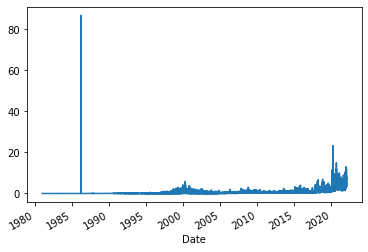

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
atr.plot(ax=ax)
data['Close'].plot(ax=ax, secondary_y=True, alpha=0.3)
plt.show()

In [29]:
df1.pipe(atr,  df1,2, 1,2,3,7,'Simple')

print(df1)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.100453   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.095213   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.088224   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.090408   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.093029   
...                ...         ...         ...         ...         ...   
2022-01-11  313.380005  316.609985  309.890015  314.980011  314.980011   
2022-01-12  319.670013  323.410004  317.079987  318.269989  318.269989   
2022-01-13  320.470001  320.880005  304.000000  304.799988  304.799988   
2022-01-14  304.250000  310.820007  303.750000  310.200012  310.200012   
2022-01-18  304.070007  309.799988  301.739990  302.649994  302.649994   

               Volume ticker  
Date  

In [34]:
my_data=atr_old(df1,2,1,2,3,7,'Simple')

In [36]:
print(my_data)
my_data.info()

[[0.11886200308799744 0.11941999942064285 0.11886200308799744 ...
  73449600 'AAPL' 0.003627501428127289]
 [0.12611599266529083 0.12667399644851685 0.12611599266529083 ...
  48630400 'AAPL' 0.005859497934579849]
 [0.1322540044784546 0.1328130066394806 0.1322540044784546 ... 37363200
  'AAPL' 0.007254503667354584]
 ...
 [320.4700012207031 320.8800048828125 304.0 ... 45366000 'MSFT'
  12.654998779296875]
 [304.25 310.82000732421875 303.75 ... 39823500 'MSFT' 11.975006103515625]
 [304.07000732421875 309.79998779296875 301.739990234375 ... 42333200
  'MSFT' 7.7650146484375]]


AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [13]:
my_data=atr(my_data,1,1,2,3,6,'Simple')

In [14]:
print(my_data)

[[375.218434 375.317124 367.116440 ... 123351100.000000 6.952313
  11.625015]
 [371.409193 376.905930 370.945404 ... 94198100.000000 9.523041 7.421067]
 [370.688794 371.715121 363.425595 ... 126765100.000000 8.328989 9.236911]
 ...
 [472.190002 472.880005 463.440002 ... 91173100.000000 6.850006 9.440002]
 [461.190002 465.089996 459.899994 ... 95849600.000000 7.315002 5.190002]
 [459.739990 459.959991 455.309998 ... 109709100.000000 7.300003 9.410004]]


In [15]:
my_data=dividerfun(my_data,5,6,7,8,9)

In [16]:
print(my_data)

[[375.218434 375.317124 367.116440 ... 1.000000 1.000000 1.000000]
 [371.409193 376.905930 370.945404 ... 0.283244 1.283244 0.000000]
 [370.688794 371.715121 363.425595 ... -0.098293 0.901707 0.000000]
 ...
 [472.190002 472.880005 463.440002 ... -0.274364 0.725636 0.000000]
 [461.190002 465.089996 459.899994 ... 0.409441 1.409441 0.000000]
 [459.739990 459.959991 455.309998 ... -0.224230 0.775770 0.000000]]


In [17]:
X = my_data[:, [7]]

In [18]:
print(X)

[[1.000000]
 [0.283244]
 [-0.098293]
 [0.143747]
 [0.020024]
 [0.585407]
 [-0.133255]
 [0.442060]
 [-0.091235]
 [0.328498]
 [-0.320084]
 [0.165739]
 [0.073481]
 [0.092801]
 [-0.103603]
 [-0.141935]
 [0.321553]
 [-0.069904]
 [-0.312001]
 [0.128590]
 [-0.186486]
 [0.255105]
 [-0.151990]
 [0.797296]
 [-0.131339]
 [-0.272278]
 [-0.000000]
 [0.468054]
 [-0.117828]
 [0.468099]
 [-0.151571]
 [0.508317]
 [-0.177041]
 [0.347273]
 [-0.214731]
 [-0.129799]
 [0.234018]
 [-0.018514]
 [-0.021877]
 [-0.045456]
 [-0.103007]
 [-0.004470]
 [0.351521]
 [0.213755]
 [-0.077977]
 [-0.123270]
 [-0.157187]
 [1.220113]
 [0.109279]
 [-0.120609]
 [-0.208211]
 [0.485561]
 [-0.141083]
 [-0.110031]
 [-0.171972]
 [0.580270]
 [-0.185882]
 [-0.124458]
 [-0.031442]
 [-0.063714]
 [-0.027592]
 [1.520258]
 [-0.097830]
 [-0.063978]
 [-0.253503]
 [0.075267]
 [0.232278]
 [-0.305512]
 [0.816531]
 [-0.275767]
 [0.237335]
 [-0.119676]
 [-0.187182]
 [-0.114105]
 [0.235596]
 [-0.018727]
 [0.619569]
 [-0.124711]
 [-0.175492]
 [0.0

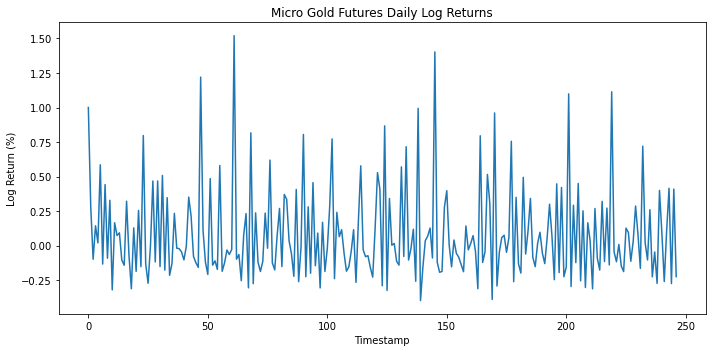

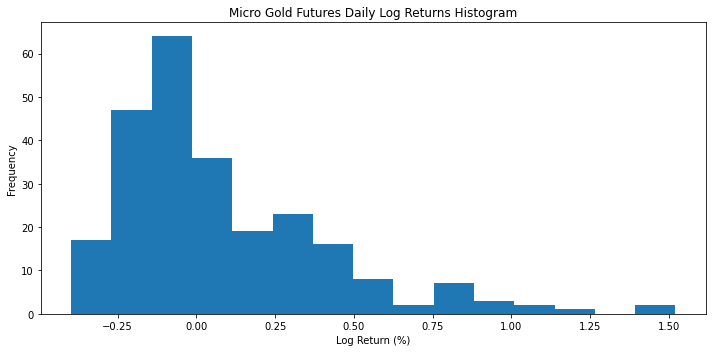

In [19]:
plt.figure()
plt.plot(X)
plt.title('Micro Gold Futures Daily Log Returns')
plt.xlabel('Timestamp')
plt.ylabel('Log Return (%)')
plt.tight_layout()

plt.figure()
plt.hist(X, bins='auto')
plt.title('Micro Gold Futures Daily Log Returns Histogram')
plt.ylabel('Frequency')
plt.xlabel('Log Return (%)')
plt.tight_layout()

In [20]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-19,373.363148,374.241455,371.794067,373.669067,51233300
2021-01-20,376.096689,379.728304,375.682231,378.840149,61836100
2021-01-21,379.432258,379.886229,378.208579,379.185547,47840100
2021-01-22,377.221727,379.077002,376.817117,377.843445,52860500
2021-01-25,378.623027,379.708533,373.481540,379.333557,70402000


In [21]:
print(my_data)

[[375.218434 375.317124 367.116440 ... 1.000000 1.000000 1.000000]
 [371.409193 376.905930 370.945404 ... 0.283244 1.283244 0.000000]
 [370.688794 371.715121 363.425595 ... -0.098293 0.901707 0.000000]
 ...
 [472.190002 472.880005 463.440002 ... -0.274364 0.725636 0.000000]
 [461.190002 465.089996 459.899994 ... 0.409441 1.409441 0.000000]
 [459.739990 459.959991 455.309998 ... -0.224230 0.775770 0.000000]]


In [22]:
nullvaluecheck = pd.DataFrame(my_data.isna().sum().sort_values(ascending=False)*100/my_data.shape[0],columns=['missing %']).head(60)
nullvaluecheck.style.background_gradient(cmap='PuBu')

AttributeError: 'numpy.ndarray' object has no attribute 'isna'